<a href="https://colab.research.google.com/github/Hirakhan15/PCOs/blob/main/PCOs(MobileNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import zipfile

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ROOT_DIR = '/content/drive/MyDrive/PCOS'
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
   number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))
   print("",dir,"" ,number_of_images[dir])

 infected  6784
 noninfected  5000


In [6]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input


In [7]:
def preprocessingImage1(path):
  image_data = ImageDataGenerator(
      zoom_range=0.2,
      shear_range=0.2,
      preprocessing_function=preprocess_input,
      horizontal_flip=True
  )
  image = image_data.flow_from_directory(
      directory=path,
      target_size=(224,224),
      batch_size=32,
      class_mode='binary'
  )
  return image


In [8]:
def preprocessionfImage2(path):
  image_data  = ImageDataGenerator(preprocessing_function= preprocess_input )
  image = image_data.flow_from_directory(
      directory=path,
      target_size=(224,224),
      batch_size=32,
      class_mode='binary'
  )
  return image


In [9]:
def datafolder(path,split):
  if not os.path.exists("./"+path):
    os.mkdir("./"+path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+path+"/"+dir)
      for img in np.random.choice(
          a=os.listdir(os.path.join(ROOT_DIR,dir)),
          size=(math.floor(split * number_of_images[dir])-5),
          replace=False):

          O = os.path.join(ROOT_DIR,dir,img)
          D = os.path.join("./"+path,dir)
          shutil.copy(O,D)
          os.remove(O)

  else:
     print("Folder already exist")

In [10]:

datafolder("train",0.7)

In [11]:
datafolder("val",0.15)

In [12]:
datafolder("test",0.15)

In [13]:
path ='/content/train'
train_data = preprocessingImage1(path)

Found 8238 images belonging to 2 classes.


In [14]:

path ='/content/test'
test_data = preprocessionfImage2(path)

Found 1757 images belonging to 2 classes.


In [15]:


path = '/content/val'
val_data = preprocessionfImage2(path)

Found 1757 images belonging to 2 classes.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet
import keras

In [17]:
base_model = MobileNet(input_shape=(224,224,3),include_top=False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
for layer in base_model.layers:
  layer.trainable = False

In [19]:
x= Flatten()(base_model.output)
x= Dense(units=1,activation='sigmoid')(x)

In [20]:
model = Model(base_model.input,x)

In [21]:
model.compile(optimizer='rmsprop',
              loss=keras.losses.binary_crossentropy,
              metrics=['accuracy'])


In [22]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

mc = ModelCheckpoint(filepath="bestmodel.h5",
                     monitor='val_accuracy',
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor="val_accuracy",
                   min_delta=0.01,
                   patience=5,
                   verbose=1)

cb = [mc,es]

In [23]:
# Balance dataset using class_weight
from sklearn.utils.class_weight import compute_class_weight

In [24]:
# Extract labels from train_data
labels = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

In [27]:
hist = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    callbacks=cb,
    class_weight=class_weights
)


Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9569 - loss: 0.4584
Epoch 1: val_accuracy did not improve from 0.96187
258/258 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step - accuracy: 0.9569 - loss: 0.4584 - val_accuracy: 0.8850 - val_loss: 2.5379
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9648 - loss: 0.4932
Epoch 2: val_accuracy did not improve from 0.96187
258/258 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.9649 - loss: 0.4929 - val_accuracy: 0.9528 - val_loss: 0.5862
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9782 - loss: 0.2655
Epoch 3: val_accuracy did not improve from 0.96187
258/258 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.9782 - loss: 0.2656 - val_accuracy: 0.9101 - val_loss: 1.9758
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9738 - loss: 0.3077
Epoch 4: val_accuracy did not improve from 0.96187
258/258 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.9738 - loss: 0.3077 - val_accuracy: 0.9585 - v

258/258 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.9804 - loss: 0.2311 - val_accuracy: 0.9659 - val_loss: 0.5257
Epoch 7/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9839 - loss: 0.2348
Epoch 7: val_accuracy did not improve from 0.96585
258/258 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.9839 - loss: 0.2346 - val_accuracy: 0.9021 - val_loss: 1.8882
Epoch 8/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9812 - loss: 0.3070
Epoch 8: val_accuracy did not improve from 0.96585
258/258 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.9812 - loss: 0.3069 - val_accuracy: 0.9465 - val_loss: 1.4062
Epoch 9/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9856 - loss: 0.1722
Epoch 9: val_accuracy did not improve from 0.96585
258/258 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.9856 - loss: 0.1722 - val_accuracy: 0.9528 - val_loss: 0.8248
Epoch 10/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9871 - loss: 0.1793
Epoch 10: val_accuracy did not imp

In [28]:
model = load_model("/content/bestmodel.h5")

In [30]:
acc = model.evaluate(test_data)[1]
print(f"Our model accuracy is {acc * 100:.2f}%")


55/55 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9705 - loss: 0.5859
Our model accuracy is 96.98%


In [31]:
h = hist.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
train_data.class_indices

{'infected': 0, 'noninfected': 1}

In [33]:

test_data.class_indices

{'infected': 0, 'noninfected': 1}

In [34]:
val_data.class_indices

{'infected': 0, 'noninfected': 1}

In [35]:

# Predict function
from keras.preprocessing import image
import tensorflow as tf

def predictimage(path):
      img = tf.keras.utils.load_img(path,target_size=(224,224))
      i = tf.keras.utils.img_to_array(img)/255
      input_arr= np.array([i])
      input_arr.shape

      pred =model.predict(input_arr)
      if pred == 1:
          print("Not Affected")
      else :
         print("Affected")
      plt.imshow(input_arr[0],vmin=0, vmax=255)
      plt.title("input Image")
      plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Affected


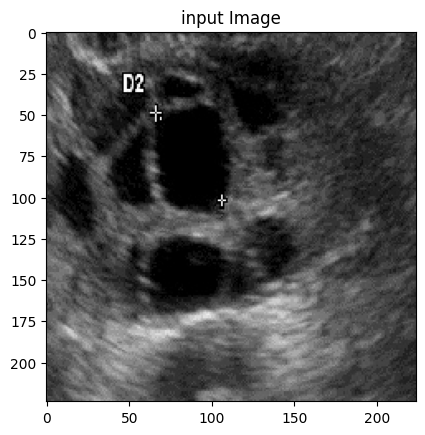

In [36]:
predictimage('/content/drive/MyDrive/Test Images/images2/pco_14.jpg')



Saving img_0_11.jpg to img_0_11.jpg
Uploaded file path: /content/img_0_11.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Not Affected


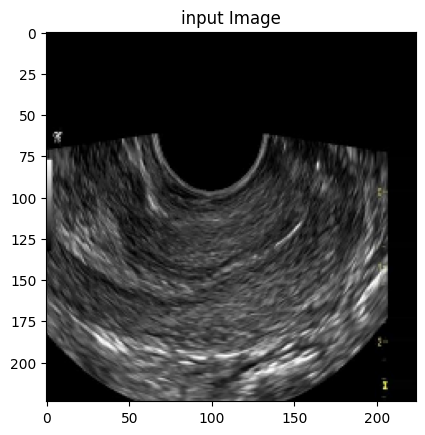

In [41]:
# Step 1: Upload image from your laptop
from google.colab import files
uploaded = files.upload()

# Step 2: Get the uploaded file name
import os
for fn in uploaded.keys():
    file_path = os.path.join("/content", fn)
    print("Uploaded file path:", file_path)

    # Step 3: Run prediction on the uploaded image
    predictimage(file_path)
